In [1]:
# Start here for Option 1

from openai import OpenAI
import pandas as pd
import os

In [2]:
# Read in data provided at https://github.com/fivethirtyeight/data/blob/master/trump-twitter/realDonaldTrump_poll_tweets.csv
tweets_df = pd.read_csv('realDonaldTrump_poll_tweets.csv')
tweets_df.head()

,id,created_at,text
0,7.656299e+17,8/16/2016 19:22:57,"It's just a 2-point race, Clinton 38%, Trump 3..."
1,7.587319e+17,7/28/2016 18:32:31,"""@LallyRay: Poll: Donald Trump Sees 17-Point P..."
2,7.583505e+17,7/27/2016 17:16:56,Great new poll - thank you!\n#MakeAmericaGreat...
3,7.575775e+17,7/25/2016 14:05:27,Great POLL numbers are coming out all over. Pe...
4,7.536034e+17,7/14/2016 14:53:46,Another new poll. Thank you for your support! ...


In [4]:
#config OpenAI client API key
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"), #  Make sure to set this env variable 
)

# OpenAI test – to see if API config + data loading worked
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": f"Categorize the following tweet into topics like policy, attacks, media, etc.: {tweets_df['text'].iloc[0]}",
        }
    ],
    model="gpt-4o-mini",
)
chat_completion.choices[0].message.content

'The tweet can be categorized under the topic of **media**, as it references polling data and includes a link likely related to news or analysis about the political race between Clinton and Trump.'

In [5]:
# Categories listed in the "What Trump talks most about on Twitter" table
categories = [
    "Policy", "Republican candidates", "Polls", "Attacking media",
    "Democratic candidates", "Attacking women (excluding Clinton)"
]

# Candidates plotted in the "The 2016 campaign in Donald Trump's tweets" graph
candidates = ["Kasich", "Bush", "Cruz", "Rubio", "Clinton"]


In [6]:
# Determines if a tweet is a retweet; All retweets in this dataset start with "RT" (and all non-retweets do not)
def is_retweet(tweet):
    return tweet.strip().startswith("RT")

# Use GPT-4o-mini to categorize a tweet by discussion topic and candidate; Produces a comma separated string listing the subset of categories and candidates the model detected in the tweet based on prompt
def categorize_tweet(tweet):
    try:
        response = client.chat.completions.create(
            messages=[
                {"role": "user", "content": f"List the subset of categories (Policy, Republican candidates, Polls, Attacking media, Democratic candidates, Attacking women excluding Clinton) that this tweet falls into, followed by the subset of candidates (Kasich, Bush, Cruz, Rubio, Clinton) that this tweet mentions.  A tweet could fit more than one category and/or mention more than one candidate. Please format as a singular list separated by commas. Example: Policy, Polls, Kasich, Rubio. If none fit, leave it blank. Only include categories that directly capture the tweet's content i.e. what a human labeller would conclude. Keep in mind that Kasich, Bush, Cruz, and Rubio were republican candidates and Clinton was a democratic candidate. Tweet: {tweet}"},
            ],
            model="gpt-4o-mini"
        )
        category = response.choices[0].message.content
        
        return category
    except Exception as e:
        print(f"Error: {e}")
        return "Error"
    
# Compute the number of "!"s (non-consequtive) in a tweet
def count_exclamations(tweet):
    return tweet.count('!')

In [7]:
# Run LLM categorization of tweets and save string with categories as 'categories' column; Takes a few minutes
tweets_df['categories'] = tweets_df['text'].apply(categorize_tweet)
tweets_df

,id,created_at,text,categories
0,7.656299e+17,8/16/2016 19:22:57,"It's just a 2-point race, Clinton 38%, Trump 3...","Polls, Clinton, Trump"
1,7.587319e+17,7/28/2016 18:32:31,"""@LallyRay: Poll: Donald Trump Sees 17-Point P...","Polls, Trump"
2,7.583505e+17,7/27/2016 17:16:56,Great new poll - thank you!\n#MakeAmericaGreat...,"Polls,"
3,7.575775e+17,7/25/2016 14:05:27,Great POLL numbers are coming out all over. Pe...,"Polls, Attacking media, Clinton"
4,7.536034e+17,7/14/2016 14:53:46,Another new poll. Thank you for your support! ...,"Polls,"
...,...,...,...,...
443,6.282555e+17,8/3/2015 17:25:48,RT @JonScottFNC: .@realDonaldTrump Surges in N...,"Polls, Trump"
444,6.282249e+17,8/3/2015 15:24:31,RT @foxandfriends: Days before the first Repub...,"Policy, Polls, Trump"
445,6.281157e+17,8/3/2015 8:10:17,"""@FoxNews: .@ericbolling: ""Polls show [@realDo...","Polls, Republican candidates, Trump"
446,6.280446e+17,8/3/2015 3:28:01,"""@CoachZachCooper: Congratulations on leading...",Polls


In [8]:
# Preprocess data steps

# Separate string of categories into columns of booleans (true if category is mentioned, false otherwise)
for category in categories + candidates:
    tweets_df[category] = tweets_df['categories'].apply(lambda x: category in x)

# Add 'is_retweet' column indicating whether the tweet is a retweet (true, false otherwise)
tweets_df['is_retweet'] = tweets_df['text'].apply(is_retweet)

# Add 'exclamation_count' column with int value of the number of (non-consequtive) '!'s in the tweet
tweets_df['exclamation_count'] = tweets_df['text'].apply(count_exclamations)

# Convert 'created_at' to a date time
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format='%m/%d/%Y %H:%M:%S', errors='coerce')

# Save processed tweet df as 'gpt_processed_tweets.csv'
tweets_df.to_csv('gpt_processed_tweets.csv', encoding='utf-8')

tweets_df

,id,created_at,text,categories,Policy,Republican candidates,Polls,Attacking media,Democratic candidates,Attacking women (excluding Clinton),Kasich,Bush,Cruz,Rubio,Clinton,is_retweet,exclamation_count
0,7.656299e+17,2016-08-16 19:22:57,"It's just a 2-point race, Clinton 38%, Trump 3...","Polls, Clinton, Trump",False,False,True,False,False,False,False,False,False,False,True,False,0
1,7.587319e+17,2016-07-28 18:32:31,"""@LallyRay: Poll: Donald Trump Sees 17-Point P...","Polls, Trump",False,False,True,False,False,False,False,False,False,False,False,False,1
2,7.583505e+17,2016-07-27 17:16:56,Great new poll - thank you!\n#MakeAmericaGreat...,"Polls,",False,False,True,False,False,False,False,False,False,False,False,False,1
3,7.575775e+17,2016-07-25 14:05:27,Great POLL numbers are coming out all over. Pe...,"Polls, Attacking media, Clinton",False,False,True,True,False,False,False,False,False,False,True,False,0
4,7.536034e+17,2016-07-14 14:53:46,Another new poll. Thank you for your support! ...,"Polls,",False,False,True,False,False,False,False,False,False,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,6.282555e+17,2015-08-03 17:25:48,RT @JonScottFNC: .@realDonaldTrump Surges in N...,"Polls, Trump",False,False,True,False,False,False,False,False,False,False,False,True,0
444,6.282249e+17,2015-08-03 15:24:31,RT @foxandfriends: Days before the first Repub...,"Policy, Polls, Trump",True,False,True,False,False,False,False,False,False,False,False,True,0
445,6.281157e+17,2015-08-03 08:10:17,"""@FoxNews: .@ericbolling: ""Polls show [@realDo...","Polls, Republican candidates, Trump",False,True,True,False,False,False,False,False,False,False,False,False,0
446,6.280446e+17,2015-08-03 03:28:01,"""@CoachZachCooper: Congratulations on leading...",Polls,False,False,True,False,False,False,False,False,False,False,False,False,1


In [ ]:
# Start here for Option 2
import pandas as pd

# Read 'gpt_processed_tweets.csv' into tweets_df
tweets_df = pd.read_csv('gpt_processed_tweets.csv')

In [9]:
start_date = '2015-11-05'
end_date = '2016-06-02'

# Filter tweets within the date range
tweets_in_date_range = tweets_df[
    (tweets_df['created_at'] >= start_date) & (tweets_df['created_at'] <= end_date)
]
print("Number of tweets in date range: ", len(tweets_in_date_range))

# Filtering DataFrame for retweets and non-retweets
non_rts = tweets_in_date_range[tweets_in_date_range['is_retweet'] == False]
retweets = tweets_in_date_range[tweets_in_date_range['is_retweet'] == True]
print("Number of non-retweets in date range: ", len(non_rts))
print("Numebr of retweets in date range: ", len(retweets))

# Calculating category percentages
non_rt_percentages = (non_rts[categories].sum(axis=0) / len(non_rts) * 100).rename('share of trump\'s TWEETS')
retweet_percentages = (retweets[categories].sum(axis=0) / len(retweets) * 100).rename('share of trump\'s RETWEETS BY OTHERS')

# Combine the data into a single DataFrame
category_split_df = pd.DataFrame({
    'Topic': categories,
    'Share of Trump\'s Tweets': non_rt_percentages.values.round(2),
    'Share of Trump\'s Retweets by Others': retweet_percentages.values.round(2)
})

# Reproduction of "What Trump talks most about on Twitter" table
category_split_df



Number of tweets in date range:  206
Number of non-retweets in date range:  198
Numebr of retweets in date range:  8


,Topic,Share of Trump's Tweets,Share of Trump's Retweets by Others
0,Policy,1.52,0.0
1,Republican candidates,14.65,12.5
2,Polls,93.94,100.0
3,Attacking media,18.69,0.0
4,Democratic candidates,5.56,0.0
5,Attacking women (excluding Clinton),0.00,0.0


In [10]:
# Convert exclamation count column into indicator columns of number of exclamations
def categorize_exclamations(count):
    if count == 0:
        return 'None'
    elif count == 1:
        return '!'
    elif count == 2:
        return '!!'
    elif count == 3:
        return '!!!'
    elif count >= 4:
        return '!!!!'
    return 'None'
tweets_in_date_range['exclamation_category'] = tweets_in_date_range['exclamation_count'].apply(categorize_exclamations)

# Compute percentages of exclamation counts
category_counts = tweets_in_date_range['exclamation_category'].value_counts(normalize=True) * 100

# Convert dictionary to DataFrame
percentage_df = pd.DataFrame(category_counts).fillna(0).round(2)

# Recreation of Trump column in "Trump is really excited to be running for president(!)" table
percentage_df

/var/folders/tx/q7qjrp8d7kg6kwf6hzblh4cm0000gn/T/ipykernel_1017/1334233111.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_in_date_range['exclamation_category'] = tweets_in_date_range['exclamation_count'].apply(categorize_exclamations)


,proportion
exclamation_category,
!,52.91
None,35.92
!!,9.71
!!!,0.97
!!!!,0.49


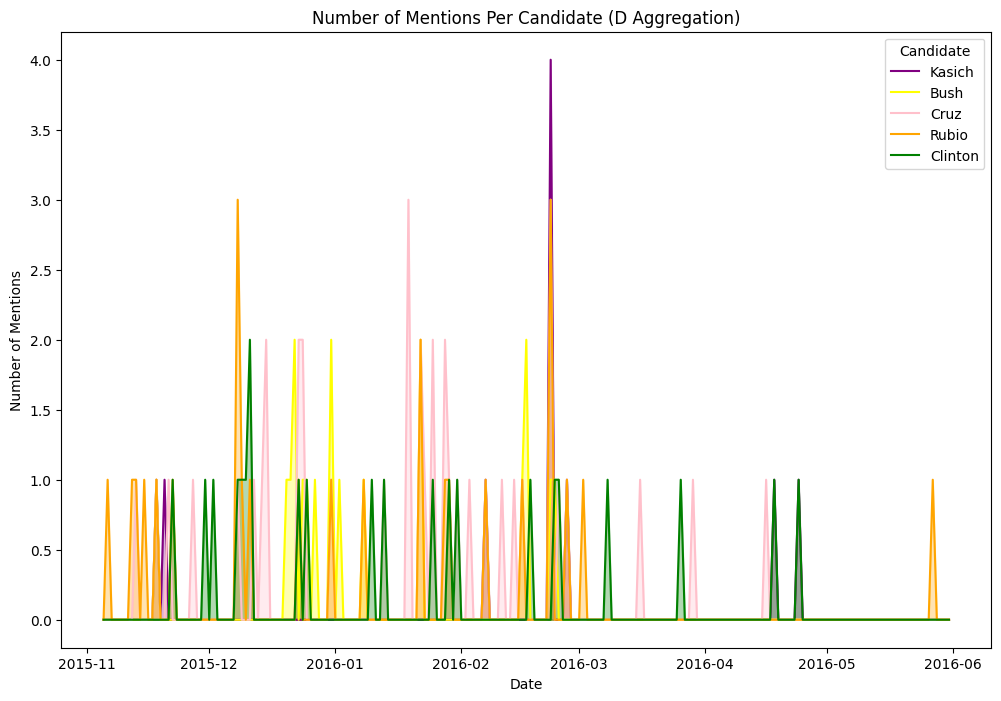

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define colors for each candidate to match original analysis
colors = {
    'Kasich': 'purple',
    'Bush': 'yellow',
    'Cruz': 'pink',
    'Rubio': 'orange',
    'Clinton': 'green'
}

# Set 'created_at' as the index
non_rts.set_index('created_at', inplace=True)

# Resample daily and sum True values (mentions)
daily_mentions = non_rts.resample('D').sum()

def plot_mentions_with_area(aggregated_mentions, colors, freq):
    plt.figure(figsize=(12, 8))

    for candidate, color in colors.items():
        sns.lineplot(data=aggregated_mentions, x=aggregated_mentions.index, y=aggregated_mentions[candidate], label=candidate, color=color)
        plt.fill_between(
            aggregated_mentions.index, aggregated_mentions[candidate],
            color=color, alpha=0.3  # Fill with partial transparency
        )

    plt.title(f'Number of Mentions Per Candidate ({freq} Aggregation)')
    plt.xlabel('Date')
    plt.ylabel('Number of Mentions')
    plt.legend(title='Candidate')
    plt.show()

# Show the plot
plot_mentions_with_area(daily_mentions, colors, 'D')
